This notebook demonstrates a complete Data Modeling Workflow using the UCI Online Retail dataset.

The goal is to showcase how raw transactional data can be transformed into different data models commonly used in industry:

🔹 Objectives

Relational Data Model (3NF)

* Normalize raw retail data into multiple related tables (Customers, Orders,Products, OrderDetails).
* Ensure data integrity and eliminate redundancy.
* Visualize the schema using an Entity-Relationship (ER) diagram.

Data Warehouse Model (Star Schema)

* Transform normalized data into a Fact table (FactSales) and Dimension tables (Customer, Product, Date).
* Optimize for analytics and reporting (OLAP).
* Visualize the schema as a Star Schema diagram.






In [27]:
# =====================================
# 📌 Step 1: Setup
# =====================================
# Core libraries
import pandas as pd
import sqlite3

# RDF modeling
!pip install rdflib graphviz
from rdflib import Graph, Literal, RDF, RDFS, URIRef, Namespace, XSD
from graphviz import Digraph

In [36]:
# =====================================
# 📌 Step 2: Load Raw Data
# Dataset: UCI Online Retail
# =====================================

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(url)

print("Raw dataset shape:", df.shape)
print("Raw dataset preview:")
display(df.head())

Raw dataset shape: (541909, 8)
Raw dataset preview:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [37]:
# =====================================================
# STEP 3: Clean Dataset
# =====================================================

# Drop rows without CustomerID (fact table needs keys)
df = df.dropna(subset=["CustomerID"])

# Convert datatypes safely
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")
df["UnitPrice"] = pd.to_numeric(df["UnitPrice"], errors="coerce")

# Remove invalid rows (negative or zero quantities/prices)
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Drop duplicates
df = df.drop_duplicates()

print("Clean dataset shape:", df.shape)

Clean dataset shape: (392692, 8)


In [56]:
# =====================================================
# STEP 4: Create Normalized 3NF Tables
# =====================================================
# Customers
customers = df[["CustomerID", "Country"]].drop_duplicates(subset=["CustomerID"])

# Products
products = df[["StockCode", "Description", "UnitPrice"]].drop_duplicates(subset=["StockCode"])

# Orders
orders = df[["InvoiceNo", "CustomerID", "InvoiceDate"]].drop_duplicates(subset=["InvoiceNo"])

# OrderDetails
order_details = df[["InvoiceNo", "StockCode", "Quantity"]].drop_duplicates(subset=["InvoiceNo"])

# Save into SQLite for relational queries
conn = sqlite3.connect("retail_clean.db")
customers.to_sql("Customers", conn, if_exists="replace", index=False)
products.to_sql("Products", conn, if_exists="replace", index=False)
orders.to_sql("Orders", conn, if_exists="replace", index=False)
order_details.to_sql("OrderDetails", conn, if_exists="replace", index=False)

print("✅ Normalized tables stored in retail_clean.db")

✅ Normalized tables stored in retail_clean.db


In [57]:
# =====================================================
# STEP 5: Verify Schema with Join Query
# =====================================================
query = """
SELECT o.InvoiceNo, o.InvoiceDate, c.CustomerID, c.Country,
       p.Description AS Product, od.Quantity, p.UnitPrice,
       (od.Quantity * p.UnitPrice) AS Revenue
FROM OrderDetails od
JOIN Orders o ON od.InvoiceNo = o.InvoiceNo
JOIN Customers c ON o.CustomerID = c.CustomerID
JOIN Products p ON od.StockCode = p.StockCode
LIMIT 10;
"""
result = pd.read_sql(query, conn)
result

,InvoiceNo,InvoiceDate,CustomerID,Country,Product,Quantity,UnitPrice,Revenue
0,536365,2010-12-01 08:26:00,17850.0,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30
1,536366,2010-12-01 08:28:00,17850.0,United Kingdom,HAND WARMER UNION JACK,6,1.85,11.10
2,536367,2010-12-01 08:34:00,13047.0,United Kingdom,ASSORTED COLOUR BIRD ORNAMENT,32,1.69,54.08
3,536368,2010-12-01 08:34:00,13047.0,United Kingdom,JAM MAKING SET WITH JARS,6,4.25,25.50
4,536369,2010-12-01 08:35:00,13047.0,United Kingdom,BATH BUILDING BLOCK WORD,3,5.95,17.85
5,536370,2010-12-01 08:45:00,12583.0,France,ALARM CLOCK BAKELIKE PINK,24,3.75,90.00
6,536371,2010-12-01 09:00:00,13748.0,United Kingdom,PAPER CHAIN KIT 50'S CHRISTMAS,80,2.55,204.00
7,536372,2010-12-01 09:01:00,17850.0,United Kingdom,HAND WARMER RED POLKA DOT,6,1.85,11.10
8,536373,2010-12-01 09:02:00,17850.0,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30
9,536374,2010-12-01 09:09:00,15100.0,United Kingdom,VICTORIAN SEWING BOX LARGE,32,10.95,350.40


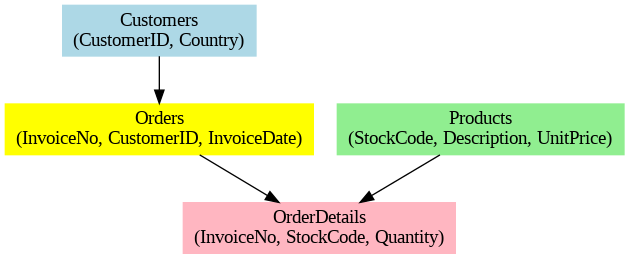

In [58]:
# =====================================================
# STEP 6: Visualize ER Diagram (3NF)
# =====================================================
dot = Digraph()

dot.node("Customers", "Customers\n(CustomerID, Country)", shape="box", style="filled", color="lightblue")
dot.node("Products", "Products\n(StockCode, Description, UnitPrice)", shape="box", style="filled", color="lightgreen")
dot.node("Orders", "Orders\n(InvoiceNo, CustomerID, InvoiceDate)", shape="box", style="filled", color="yellow")
dot.node("OrderDetails", "OrderDetails\n(InvoiceNo, StockCode, Quantity)", shape="box", style="filled", color="lightpink")

dot.edge("Customers", "Orders")
dot.edge("Orders", "OrderDetails")
dot.edge("Products", "OrderDetails")

dot.render("er_diagram", format="png")
Image("er_diagram.png")

In [59]:
# =====================================================
# STEP 7: Create Fact Table (Star Schema)
# =====================================================
query = """
SELECT o.InvoiceNo, o.CustomerID, o.InvoiceDate, c.Country,
       p.StockCode, p.Description, od.Quantity, p.UnitPrice,
       (od.Quantity * p.UnitPrice) AS Revenue
FROM OrderDetails od
JOIN Orders o ON od.InvoiceNo = o.InvoiceNo
JOIN Customers c ON o.CustomerID = c.CustomerID
JOIN Products p ON od.StockCode = p.StockCode
"""
fact_sales = pd.read_sql(query, conn)

print("Fact table shape:", fact_sales.shape)
fact_sales.head()

Fact table shape: (18532, 9)


,InvoiceNo,CustomerID,InvoiceDate,Country,StockCode,Description,Quantity,UnitPrice,Revenue
0,536365,17850.0,2010-12-01 08:26:00,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30
1,536366,17850.0,2010-12-01 08:28:00,United Kingdom,22633,HAND WARMER UNION JACK,6,1.85,11.10
2,536367,13047.0,2010-12-01 08:34:00,United Kingdom,84879,ASSORTED COLOUR BIRD ORNAMENT,32,1.69,54.08
3,536368,13047.0,2010-12-01 08:34:00,United Kingdom,22960,JAM MAKING SET WITH JARS,6,4.25,25.50
4,536369,13047.0,2010-12-01 08:35:00,United Kingdom,21756,BATH BUILDING BLOCK WORD,3,5.95,17.85


In a Star Schema, we add a DimDate (Date Dimension) even though raw data already has an InvoiceDate column.

🔹 Reasons:

Consistent Time Analysis → A separate date dimension makes it easy to group sales by day, month, quarter, year without recalculating every time.

Time Intelligence →  Power BI can use DimDate for Year-to-Date (YTD), Month-to-Date (MTD), Previous Year comparisons, seasonality.

Flexibility → You can add more date-related attributes (e.g., DayOfWeek, IsHoliday, WeekNumber, FiscalYear) later without changing FactSales.

Best Practice in Data Warehousing → A dedicated calendar dimension is standard in star schemas to separate transactional facts from descriptive attributes.

In [60]:
# =====================================================
# STEP 8: Create DimDate Table
# =====================================================
fact_sales["Date"] = pd.to_datetime(fact_sales["InvoiceDate"])
dim_date = fact_sales[["Date"]].drop_duplicates().reset_index(drop=True)

dim_date["DateID"] = dim_date.index + 1
dim_date["Day"] = dim_date["Date"].dt.day
dim_date["Month"] = dim_date["Date"].dt.month
dim_date["Year"] = dim_date["Date"].dt.year

# Merge DateID into FactSales
fact_sales = fact_sales.merge(dim_date[["Date", "DateID"]], on="Date", how="left")

dim_date.head()

,Date,DateID,Day,Month,Year
0,2010-12-01 08:26:00,1,1,12,2010
1,2010-12-01 08:28:00,2,1,12,2010
2,2010-12-01 08:34:00,3,1,12,2010
3,2010-12-01 08:35:00,4,1,12,2010
4,2010-12-01 08:45:00,5,1,12,2010


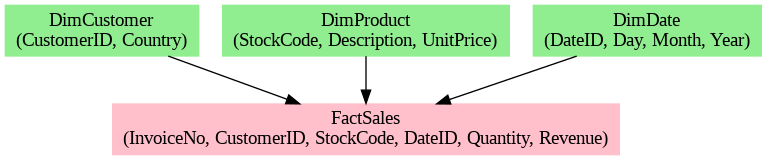

In [61]:
# =====================================================
# STEP 9: Visualize Star Schema
# =====================================================
dot = Digraph(comment="Star Schema for Retail Data")

# Fact Table
dot.node("FactSales",
         "FactSales\n(InvoiceNo, CustomerID, StockCode, DateID, Quantity, Revenue)",
         shape="box", style="filled", color="pink")

# Dimension Tables
dot.node("DimCustomer", "DimCustomer\n(CustomerID, Country)", shape="box", style="filled", color="lightgreen")
dot.node("DimProduct", "DimProduct\n(StockCode, Description, UnitPrice)", shape="box", style="filled", color="lightgreen")
dot.node("DimDate", "DimDate\n(DateID, Day, Month, Year)", shape="box", style="filled", color="lightgreen")

# Relationships
dot.edge("DimCustomer", "FactSales")
dot.edge("DimProduct", "FactSales")
dot.edge("DimDate", "FactSales")

# Save and render
dot.render("star_schema", format="png")
Image("star_schema.png")

In [62]:
fact_sales.to_csv("FactSales.csv", index=False)
customers.to_csv("DimCustomer.csv", index=False)
products.to_csv("DimProduct.csv", index=False)
dim_date.to_csv("DimDate.csv", index=False)

print("✅ Files saved in Colab environment")

✅ Files saved in Colab environment


In [63]:
from google.colab import files

files.download("FactSales.csv")
files.download("DimCustomer.csv")
files.download("DimProduct.csv")
files.download("DimDate.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In this notebook, we explored the complete workflow of data modeling using the Online Retail dataset:

🔹 Key Takeaways

Relational Data Modeling (3NF)

* We normalized the raw dataset into four linked tables: Customers, Orders, Products, OrderDetails.
* This reduced redundancy and maintained data integrity.
* The ER diagram helped visualize entity relationships.

Data Warehouse Modeling (Star Schema)
* We transformed transactional data into a FactSales table linked to dimension tables.
* This model is optimized for OLAP queries such as revenue by product, customer, or country.
* The Star Schema diagram clearly showed how fact and dimension tables connect.

Scalability and Real-World Application
* The workflow demonstrated here is directly applicable to enterprise use cases.
* Data modeling is not just about storing data efficiently but also about enabling fast insights and analytics.
* While relational models are best for transactions (OLTP), star schemas shine in analytics (OLAP).